# Analysis of "Welfare"


In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import ast

def load_csv_files(subfolder_name):
    notebook_path = os.path.dirname(os.path.abspath('__file__'))
    data_folder_path = os.path.join(notebook_path, 'data', subfolder_name)

    all_dataframes = []
    
    # Get a list of all files in the subfolder
    files = os.listdir(data_folder_path)

    # Loop through each file and load it as a pandas DataFrame
    for file in files:
        if file.endswith('.csv'):
            file_path = os.path.join(data_folder_path, file)
            df = pd.read_csv(file_path)
            all_dataframes.append(df)

    # Concatenate all DataFrames into one, stacking them on top of each other
    combined_df = pd.concat(all_dataframes, ignore_index=True)

    return combined_df

# Usage:
subfolder_name = '2023-07-dummy_data'
data = load_csv_files(subfolder_name)

# Remove duplicates based on all columns
data.drop_duplicates(inplace=True)

# restrict to sessions:
def restrict_to_sessions(data, session_codes):
    return data[data['session.code'].isin(session_codes)]

session_codes = []
if session_codes != []:
    data = restrict_to_sessions(data, session_codes)

data.columns = data.columns.str.replace('participant.', '')

In [140]:

# List of pages to check against
pages_to_exclude = ['Welcome', 'Consent']

# Create a new column 'not_in_list' based on the condition
data['started_experiment'] = data['_current_page_name'].apply(lambda x: x not in pages_to_exclude and pd.notna(x))

# Create a new column 'finished_experiment' based on the condition
data['finished_experiment'] = data['_current_page_name'].apply(lambda x: x == 'Redirect')


# Calculate the number of rows with 'finished_experiment' equal to True
finished_experiment_count = sum(data['finished_experiment'])

# Calculate the number of rows with 'started_experiment' equal to True
started_experiment_count = sum(data['started_experiment'])

# Calculate attrition
completion = finished_experiment_count / started_experiment_count

print('Completion rate: ',completion)

# Filter the DataFrame to only include rows where 'finished_experiment' is True
data = data[data['finished_experiment'] == True]

data.rename(columns={'welfare.1.player.'+cq+'_mistakes': 'mistakes_'+cq for cq in ['cq1','cq2','cq3','cq4','cq5']}, inplace=True)

data['mistakes_total'] = data['mistakes_cq1'] + data['mistakes_cq2'] + data['mistakes_cq3'] + data['mistakes_cq4'] + data['mistakes_cq5']


# Assuming 'df' is your DataFrame
total_entries = len(data)  # Total number of entries in the column

# Count the occurrences where the condition is satisfied (value == 1)
count_equal_1 = data['welfare.1.player.confirm'].eq(1).sum()

# Calculate the share of entries that equal 1
share_equal_1 = count_equal_1 / total_entries

print('Participants who confirmed their answers the first time: ',share_equal_1)

Completion rate:  1.0
Participants who confirmed their answers the first time:  0.75


In [135]:

def calculate_ES_wtp(row):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.ES_wtp"]

data['ES_wtp'] = data.apply(calculate_ES_wtp, axis=1)

def calculate_Trad_wtp(row):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.Trad_wtp"]
data['Trad_wtp'] = data.apply(calculate_Trad_wtp, axis=1)


def calculate_ES_wtp2(row):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.ES_wtp2"]

data['ES_wtp2'] = data.apply(calculate_ES_wtp2, axis=1)

def calculate_Trad_wtp2(row):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.Trad_wtp2"]
data['Trad_wtp2'] = data.apply(calculate_Trad_wtp2, axis=1)


def calculate_ES_wtp3(row):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.ES_wtp3"]

data['ES_wtp3'] = data.apply(calculate_ES_wtp3, axis=1)

def calculate_Trad_wtp3(row):
    return row[f"welfare.{int(row['welfare.1.player.confirm'])}.player.Trad_wtp3"]
data['Trad_wtp3'] = data.apply(calculate_Trad_wtp3, axis=1)



def get_wtp_bound(wtp3): 
    if wtp3==None:
        return "WTP is None"
    cutoff = json.loads(wtp3)['cutoff']
    parts = cutoff.split(":")
    side = parts[0]
    row = int(parts[1])

    if side == "right":
        row = row-1
        side="left"

    WTP_VALUES = [1]+[2, 3, 4, 5, 7, 10, 15, 25, 50] +[float('inf')]

    WTP_bound = (WTP_VALUES[row+1],WTP_VALUES[row+2])
    return WTP_bound


for el in ['ES','Trad']:
    data[f'{el}_wtp3_bounds'] = data[f'{el}_wtp3'].apply(lambda x: get_wtp_bound(x) if pd.notna(x) else x)

def modify_column1(entry, col2_value, col3_value):
    if col2_value == 3:
        return (0, 0)
    elif col2_value == 2:
        
        if col3_value == 1:
                return (0,0)
        elif col3_value == 2:
                return (-float('inf'), 0)
    
    elif col2_value == 1:
        if col3_value == 2:
            return (0, 1)
        else: 
            return entry
        
def calculate_average(tup):
    if np.inf in tup or -np.inf in tup:
        return tup[1] if tup[0] in [-np.inf,np.inf] else tup[0]
    return (tup[0] + tup[1]) / 2

# Apply the function to modify 'Column1'
for el in ['ES','Trad']:
    data[f'{el}_wtp3_bounds'] = data.apply(lambda row: modify_column1(row[f'{el}_wtp3_bounds'], row[f'{el}_wtp'], row[f'{el}_wtp2']), axis=1)

    data[f'{el}_wtp_point'] = data[f'{el}_wtp3_bounds'].apply(calculate_average)



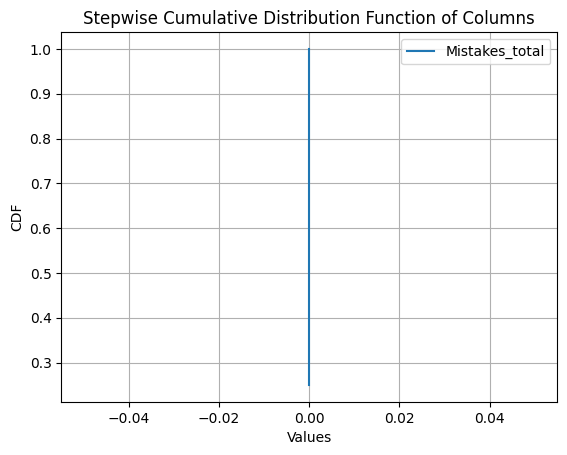

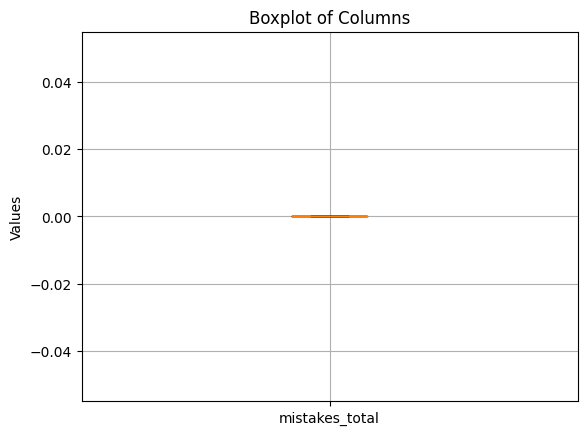

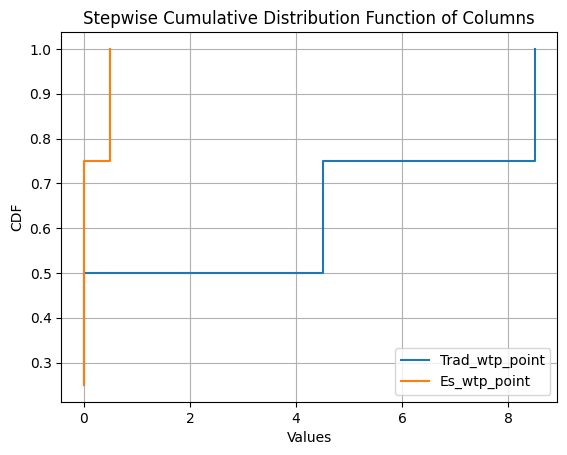

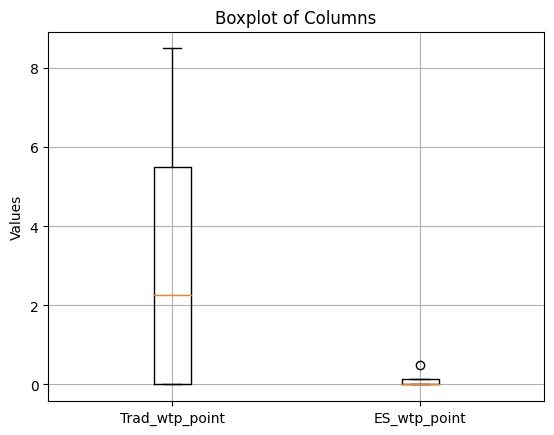

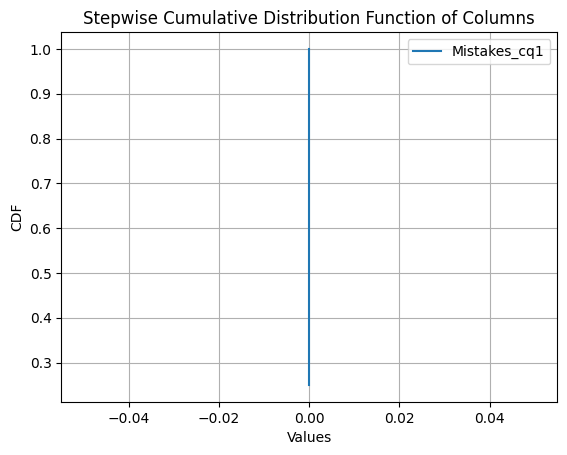

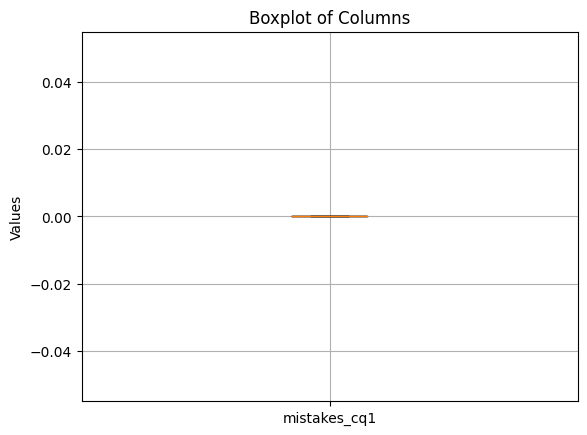

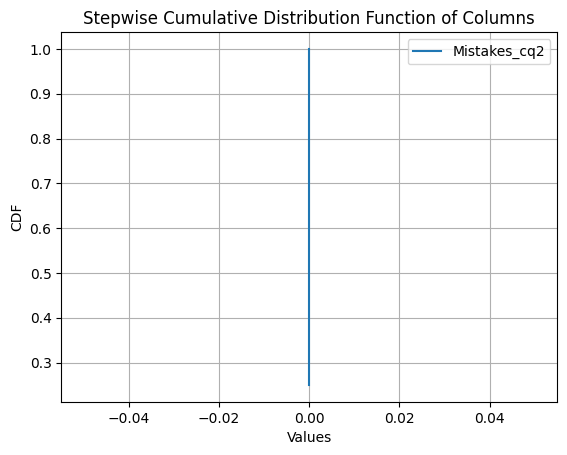

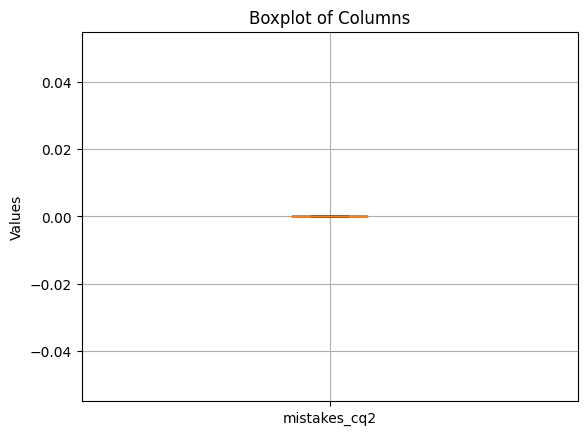

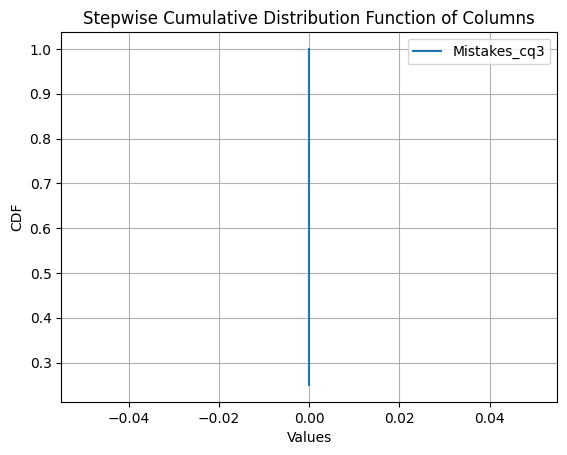

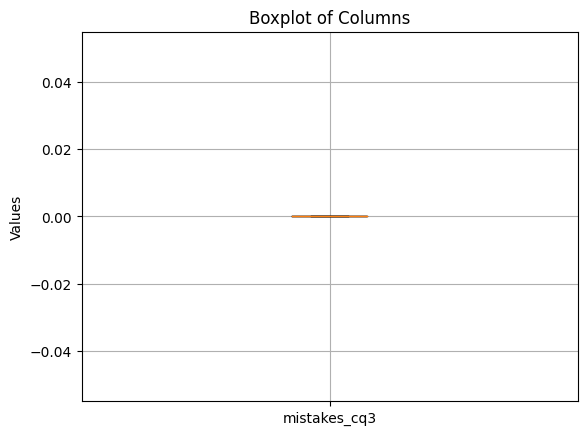

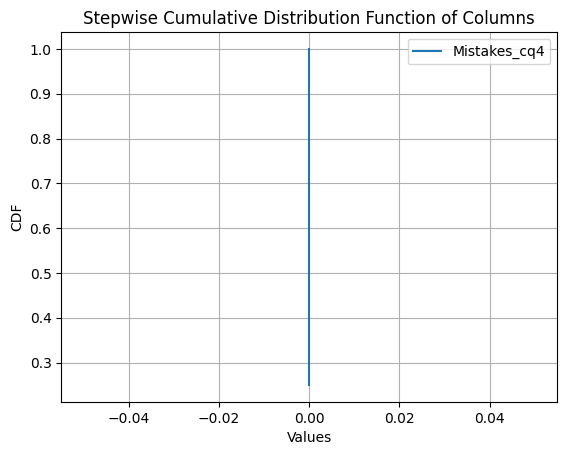

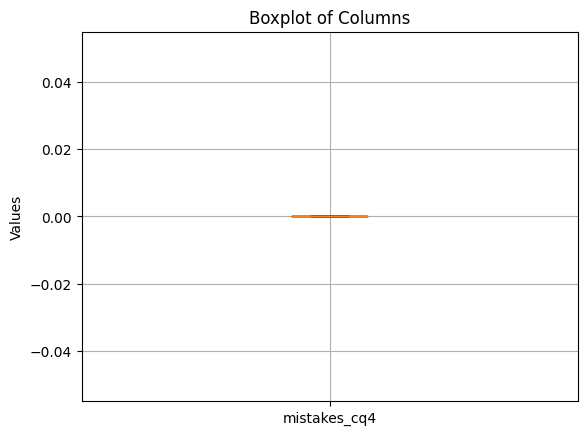

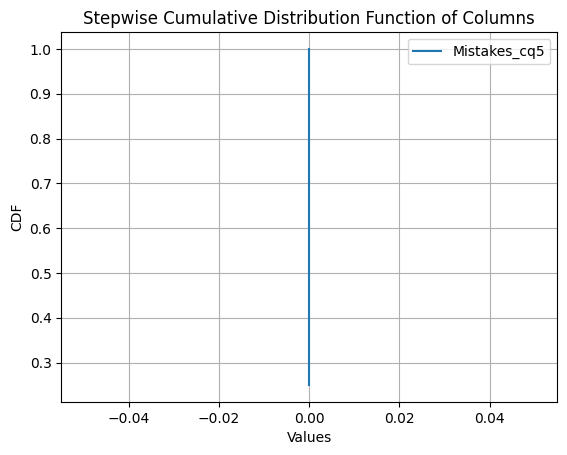

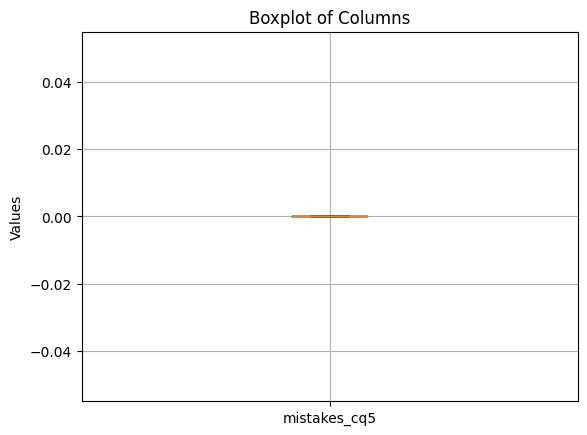

In [137]:
# Create the 'output' folder if it doesn't exist
output_folder = os.path.join(os.getcwd(), 'output')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Create the 'subfolder' inside the 'output' folder if it doesn't exist
subfolder_path = os.path.join(output_folder, subfolder_name)
if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)



def plot_and_save_cdf(data, column_names, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Loop through the list of column names
    for column_name in column_names:
        # Calculate and plot the stepwise CDF
        sorted_data = np.sort(data[column_name])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
        ax.step(sorted_data, cdf, where='post', label=column_name.capitalize())

    # Add labels and title
    ax.set_xlabel('Values')
    ax.set_ylabel('CDF')
    ax.set_title(f'Stepwise Cumulative Distribution Function of Columns')
    ax.legend()

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the figure in the subfolder
    file_path = os.path.join(subfolder_path, f'stepwise_cdf.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()


def plot_and_save_boxplot(data, column_names, subfolder_name):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Data for boxplot
    data_to_plot = [data[column_name] for column_name in column_names]

    # Create the boxplot
    ax.boxplot(data_to_plot, labels=column_names)

    # Add labels and title
    ax.set_ylabel('Values')
    ax.set_title(f'Boxplot of Columns')

    # Show the plot
    ax.grid(True)

    # Create the Data directory if it doesn't exist
    if not os.path.exists('Output'):
        os.mkdir('Output')

    # Create the subfolder if it doesn't exist
    subfolder_path = os.path.join('Output', subfolder_name)
    if not os.path.exists(subfolder_path):
        os.mkdir(subfolder_path)

    # Save the boxplot in the subfolder
    file_path = os.path.join(subfolder_path, f'boxplot.png')
    plt.savefig(file_path)

    # Display the plot (optional)
    plt.show()

# Call the function to plot and save the CDF for 'mistakes_total'
plot_and_save_cdf(data, ['mistakes_total'], subfolder_name)

# Call the function to plot and save the boxplot for 'mistakes_total'
plot_and_save_boxplot(data, ['mistakes_total'], subfolder_name)



# Call the function to plot and save the CDF for 'mistakes_total'
plot_and_save_cdf(data, ['Trad_wtp_point','ES_wtp_point'], subfolder_name)

# Call the function to plot and save the boxplot for 'mistakes_total'
plot_and_save_boxplot(data, ['Trad_wtp_point','ES_wtp_point'], subfolder_name)





for question in ['mistakes_cq1', 'mistakes_cq2', 'mistakes_cq3', 'mistakes_cq4','mistakes_cq5']:
    # Call the function to plot and save the CDF for question
    plot_and_save_cdf(data, [question], subfolder_name)

    # Call the function to plot and save the boxplot for question
    plot_and_save_boxplot(data, [question], subfolder_name)




# UNTIL HERE

In [ ]:





# Calculate the time difference and create a new column 'task_duration'
data['task_duration'] = data['end_task'] - data['start_task']

# Calculate the time difference and create a new column 'task_duration'
data['study_duration'] = data['finished'] - data['start']




# Select only the desired columns
selected_columns = ['feedback', 'treatment', 'payoff', 'study_duration']
selected_data = data[selected_columns]

# Save the selected data to a CSV file in the 'subfolder'
file_path = os.path.join(subfolder_path, 'feedback.csv')
selected_data.to_csv(file_path, index=False)




In [202]:
# Step 1: Create a list of strings in the required format
rows_as_text = [f"{label},{bonus_payment}" for label, bonus_payment in zip(data['label'], data['bonus_payment'])]

# Step 2: Write the strings to a text file
with open('bonus_payment.txt', 'w') as file:
    file.write("\n".join(rows_as_text))

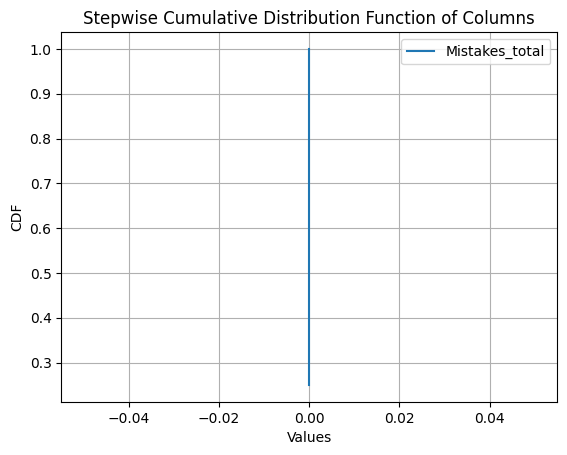

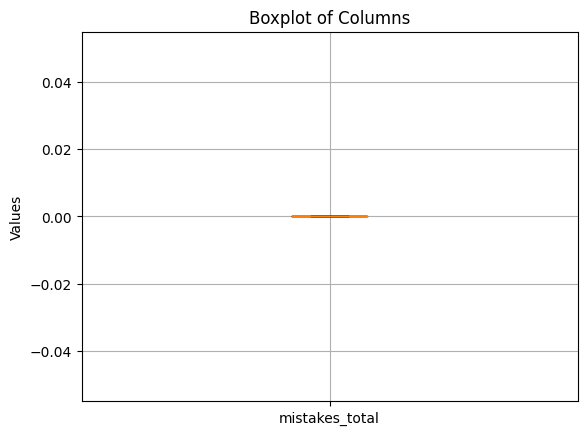

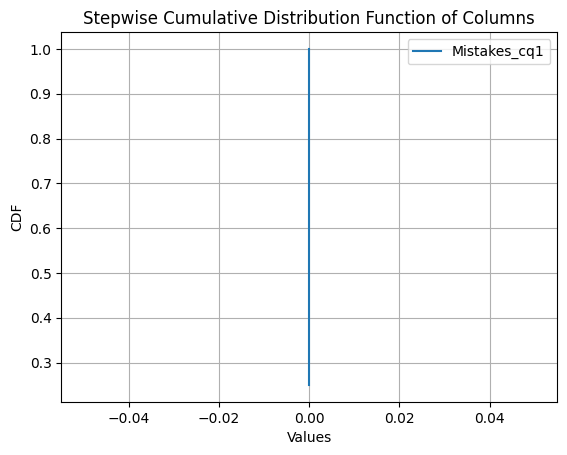

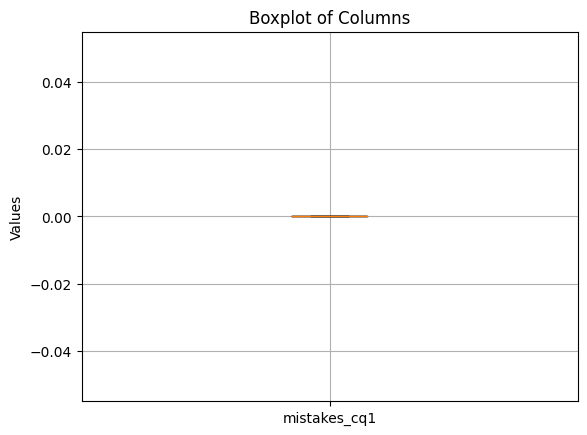

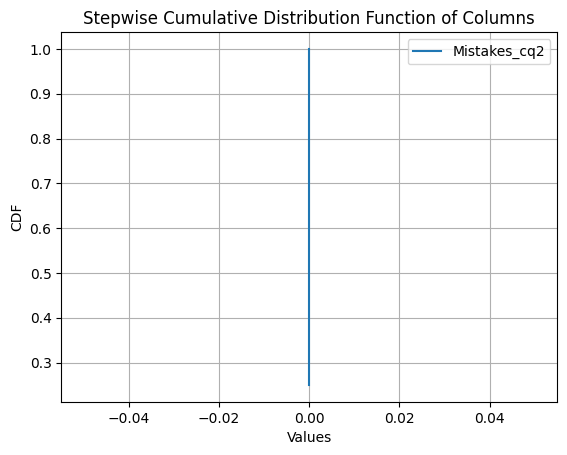

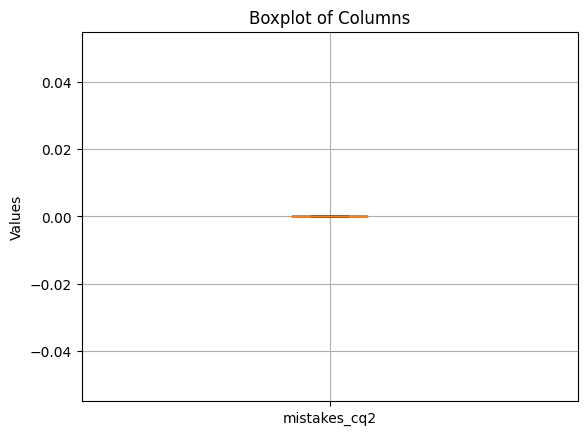

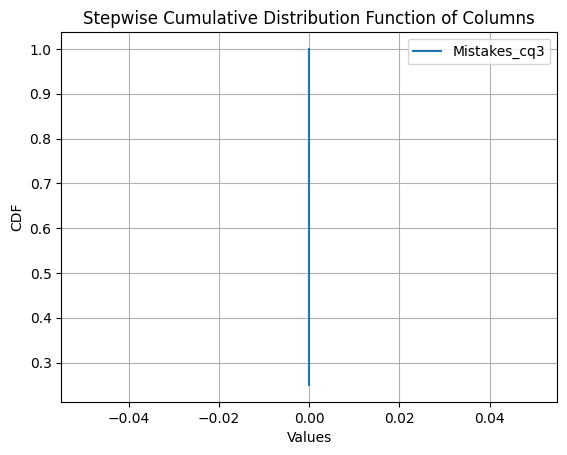

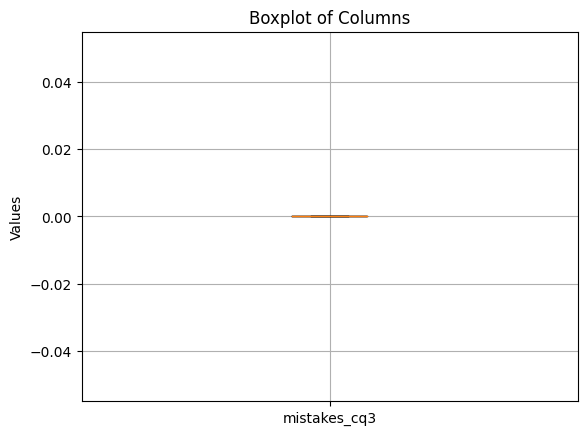

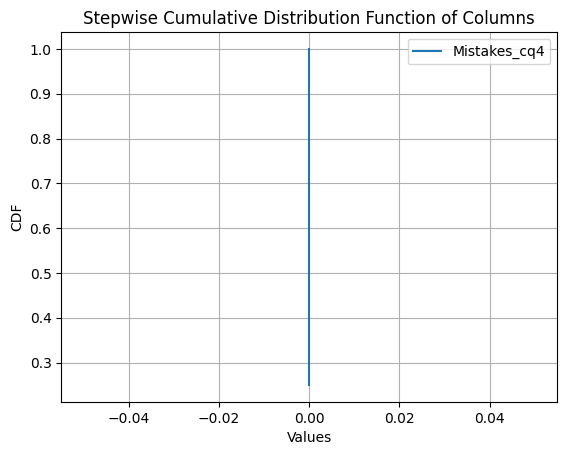

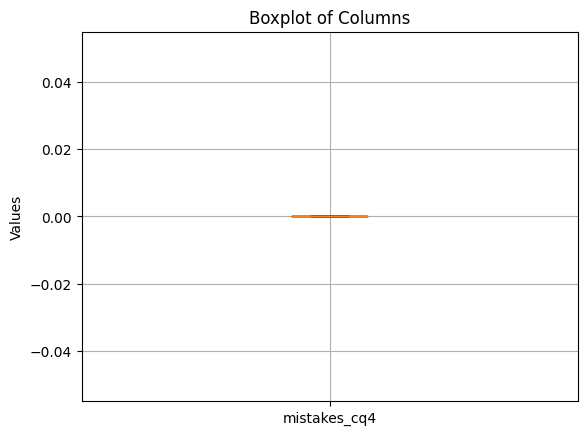

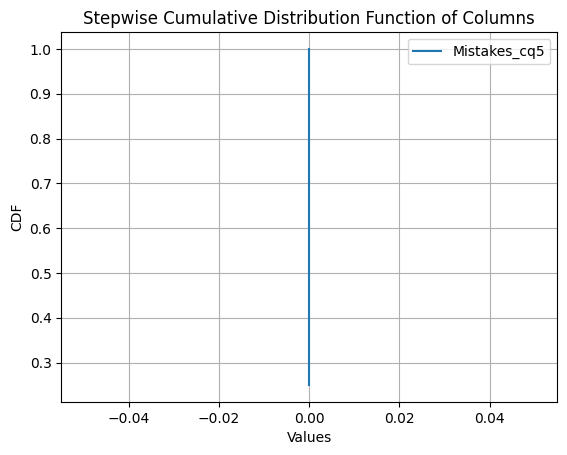

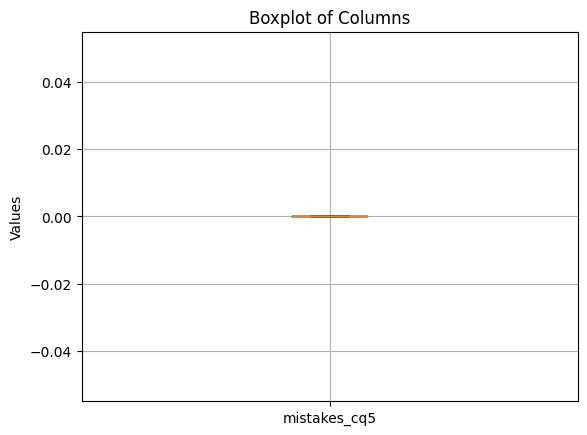